# EDA

- Os Notebook [1. EDA](1.%20EDA.ipynb) e [2. Features](2.%20Criando%20as%20features.ipynb) são a base para as análises e aplicações que serão feitas posteriormente.

# Ìndice

1. [Resumo e objetivo](#Resumo-e-Objetivo)
-  [EDA Básicas](#EDA-Básica)
    - [NaNs](#NaNs)
    - [Número de categórias únicas](#unique)
    - [Correlação](#Correlação)
    - [Estatística com Pandas](#pan)
    - [Outliers](#Outliers)
    - [O que vende mais?](#vendas)
    - [Visualização do número de itens vendidos por loja](#viz_cnt)
    - [Resumo da EDA básica](#eda_basic)
-  [EDA das Novas Features](#EDA-das-Novas-Features) <- Parei aqui
    - [Qual categória remunera mais?](#cat_rev)
    - [Visualização da receito por loja](#viz_rev)
    - [Correlações das features novas](#new_corr)  
    - [Resumo da EDA das novas features](#eda_not_basic)
-  [Show off](#Show-off)

### Coisas a serem feitas:
- [ ] Arrumar o gráfico do plotly.
    - [ ] Colocar hovers direito.
    - [ ] Arrumar os eixos.
    - [ ] Colocar uma legenda decente.
- [ ] Colocar todas as referências.
- [ ] Fazer o resumo.
- [x] Colocar o link pra correlação usando mais features.
- [ ] Explicar boxplot.
- [x] Gráfico do Item revenue. (igual ao item_category_id por mês)
- [x] Mesmo gráfico do anterior só que com a feature item_type.
- [ ] Colocar uns plots do lado shop=0,1,9,33... no gráfico dos pontinhos
- [x] Colocar as outras features criadas. (médias)
- [ ] Renomear Dezembro e Maio, colocar semestre e ano.
- [x] Falar que tem uma função de reescala para o gráfico dos pontinhos.

### Ideias para dataviz:
- [ ] Olhar vendas/receita de categórias por cidade.
- [ ] Agrupar as lojas por vendas, por receita e por cidade.

# Resumo e Objetivos

# File descriptions:

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

# Data fields:

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

[Kaggle Competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

# Carregando os arquivos

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import folium
from folium.plugins import HeatMap
import folium.plugins as plugins

import missingno as msno

import datetime

from sklearn.preprocessing import LabelEncoder

path = 'data'

train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')
geo = pd.read_csv(path + '/geo_shop.csv')

### Reunindo o o dataset.

Vou juntar todos os datasets em um único dataframe e descartar features categóricas. Elas vão ser tratadas depois de entrarmos no notebook [2. Features](2.%20Criando%20as%20features.ipynb).

In [2]:
train_full = pd.merge(train, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
train_full = pd.merge(train_full, shops, on='shop_id', how='left')

In [3]:
train_full.date=train_full.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [4]:
train_clean = train_full.drop(['date', 'item_name', 'shop_name', 'item_category_name'], axis=1)

----------------------

# EDA Básica

Fazer uma EDA simples é sempre um bom começo.

- [NaNs](#NaNs)
- [Número de categórias únicas](#unique)
- [Correlação](#Correlação)
- [Estatística com Pandas](#pan)
- [Outliers](#Outliers)
- [O que vende mais?](#vendas)
- [Visualização das vendas por loja](#viz_cnt)
- [Resumo da EDA básica](#eda_basic)

A cara do nosso dataset sem as features categóricas.

In [5]:
train_clean.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


In [6]:
train_clean.shape

(2935849, 6)

### NaNs

Testando se existe algum Nan ou Null no dataset.

In [7]:
print(train_clean.isna().any())
print(train_clean.isnull().any())

date_block_num      False
shop_id             False
item_id             False
item_price          False
item_cnt_day        False
item_category_id    False
dtype: bool
date_block_num      False
shop_id             False
item_id             False
item_price          False
item_cnt_day        False
item_category_id    False
dtype: bool


 <a name="backnan"></a> Parece que o dataset tá Ok. Mesmo assim vamos visualizar essas coisas. Linhas horizontais brancas significam Nans, como não temos nenhum tudo vai ficar cinza.

Deixei um exemplo [aqui](#nan) caso queira ver como fica um dataset com Nans.

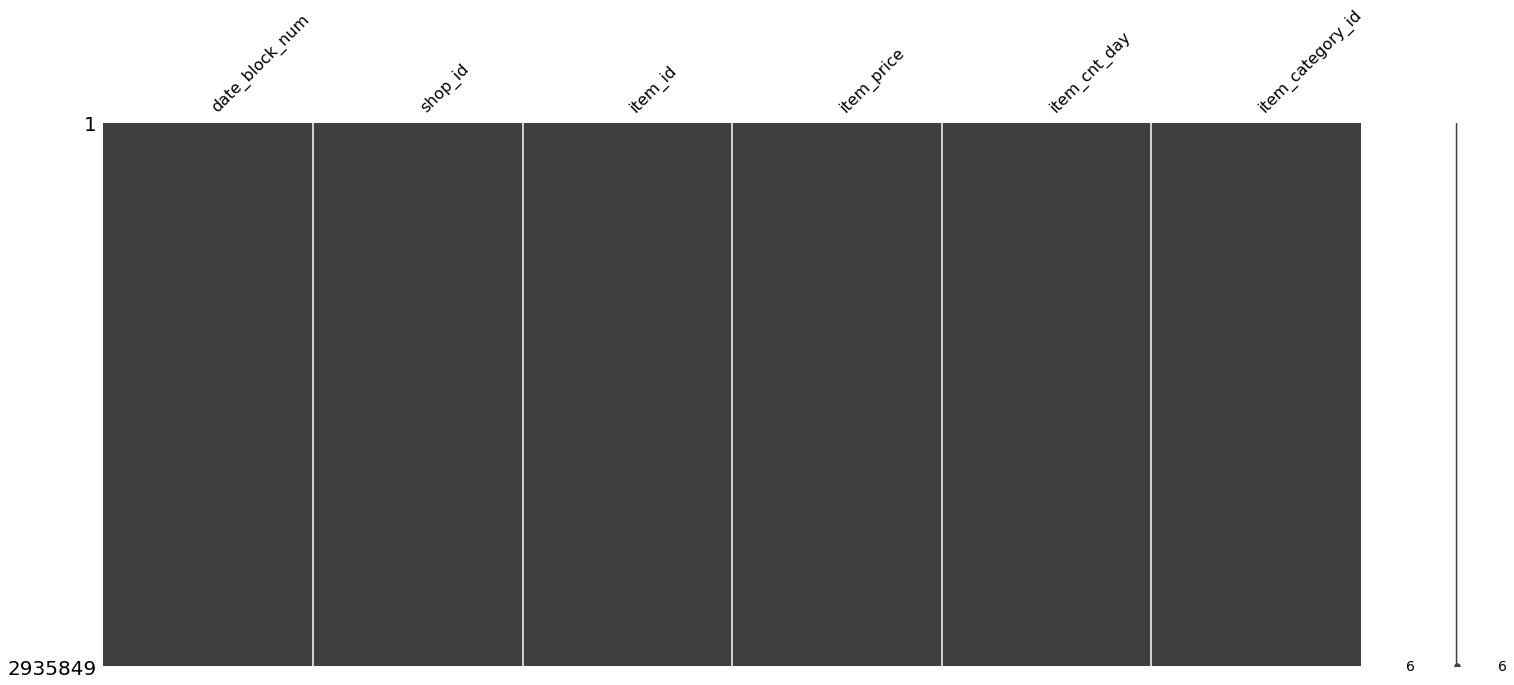

In [8]:
msno.matrix(train_clean.loc[:, :])
plt.show()

### <a name="unique"></a> Número de itens, shoppings, meses e categórias únicas.

In [9]:
print('Meses:', train_clean['date_block_num'].nunique())
print('Shoppings:', train_clean['shop_id'].nunique())
print('Itens:', train_clean['item_id'].nunique())
print('Categórias:', train_clean['item_category_id'].nunique())

Meses: 34
Shoppings: 60
Itens: 21807
Categórias: 84


> Temos poucos meses no dataset, isso pode ser um problema porque temos poucos dados para serem dividos em treino e teste.

---------

### Correlação

O mapa de correlações serve para ver como as features variam uma em relação a outra. Um exemplo simples é a correlação do preço de uma casa e seu tamanho. Nessa situação, uma correlação positiva entre essas features indica que, uma casa grande é uma casa cara. Só um último lembrete: **Correlação não implica em causalidade**, um evento pode estar correlacionado mas não necessariamente vai causar o outro. Um site interessante para ver isso é o [spurious correlations](http://www.tylervigen.com/spurious-correlations).

Essas features básicas não geram um mapa interessante de correlação. Depois que criarmos features novas ([2. Features](2.%20Criando%20as%20features.ipynb)), teremos um mapa mais interessante. [Correlações das features novas](#new_corr).

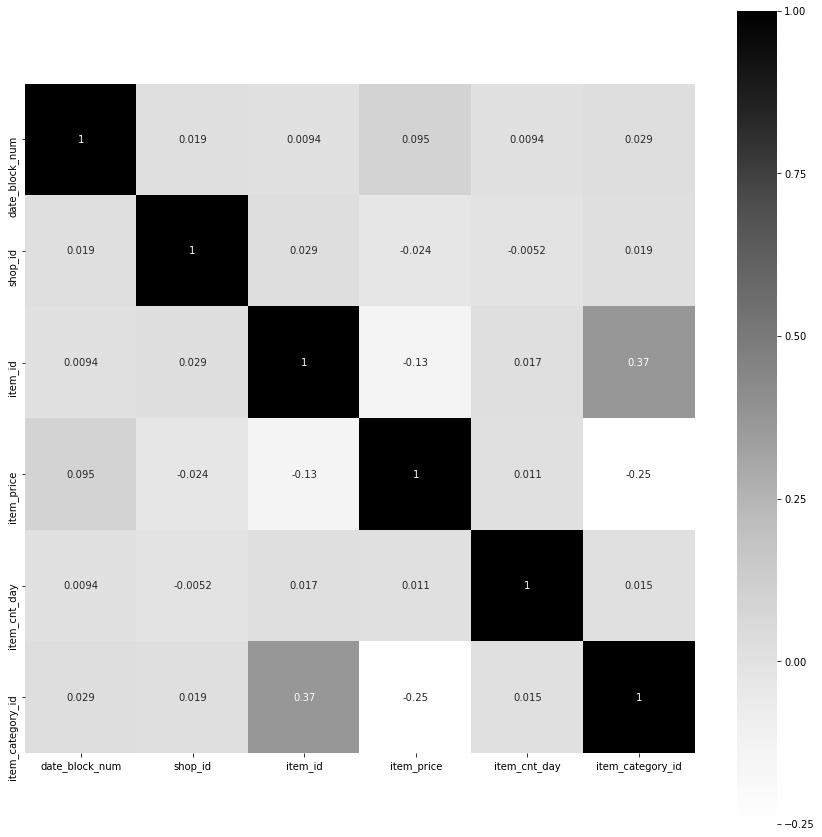

In [10]:
correlation = train_clean.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='Greys')
plt.show()

------------------

###  <a name="pan"></a> Estatística com Pandas

Vamos utilizar o pandas para obter algumas estatísticas.

In [11]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


#### **Obs.:**
- O minímo do item_price é negativo. (Provavelmente uma promoção ou coisa do tipo)
- O minímo do item_cnt_day é negativo. (Provavelmente são devoluções)
- O máximo do item_price é bem alto. (Um dos itens tem valor elevado demais) (**Outlier**)
- O máximo do item_cnt_day é bem alto. (Venderam um monte de itens de uma vez)(**Outlier**)
- O desvio padrão std dos dois também está meio alto. (Isso pode gerar problemas em alguns modelos)

> De forma geral todos os itens destacados podem causar problemas para os modelos que serão usados.

------------------

### Outliers

Histogramas, basicamente, contam o número de valores encontrados no seu dataframe. Por exemplo:

- Dataset: $[1,1,1,2,2,3,3,4,4,4]$ => Histograma: $[3,2,2,3]$

Então, os valores no eixo $y$ do seu histograma vai ser $[3,2,2,3]$ e o no eixo $x$ são $[1,2,3,4]$

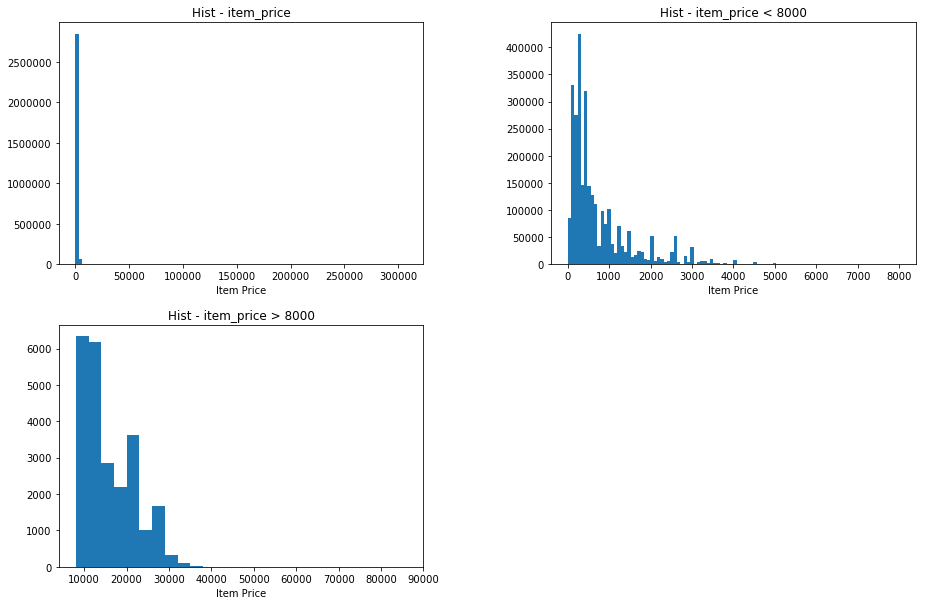

In [12]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
plt.hist(train_clean['item_price'], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')

plt.subplot(222)
plt.hist(train_clean['item_price'][train_clean.item_price < 8000], bins = 100)
plt.title('Hist - item_price < 8000')
plt.xlabel('Item Price')

plt.subplot(223)
plt.hist(train_clean['item_price'][train_clean.item_price > 8000], bins = 100)
plt.title('Hist - item_price > 8000')
plt.xlim(4000, 90000)
plt.xlabel('Item Price')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

**Obs.:**
- O primeiro gráfico não diz muito. Só me fala que muitos itens tem valores pequenos.
- O segundo gráfico (valores < 8000), me mostra que realmente são vendidos mais itens com valores baixos. 
- O terceiro gráfico (valores > 8000), poucas vendas de itens caros, apesar de ter $6.000$ vendas de itens que valem mais de $10.000$.

Uma forma melhor de observar se existem itens com valores muito discrepantes, é utilizando o plot de caixas.

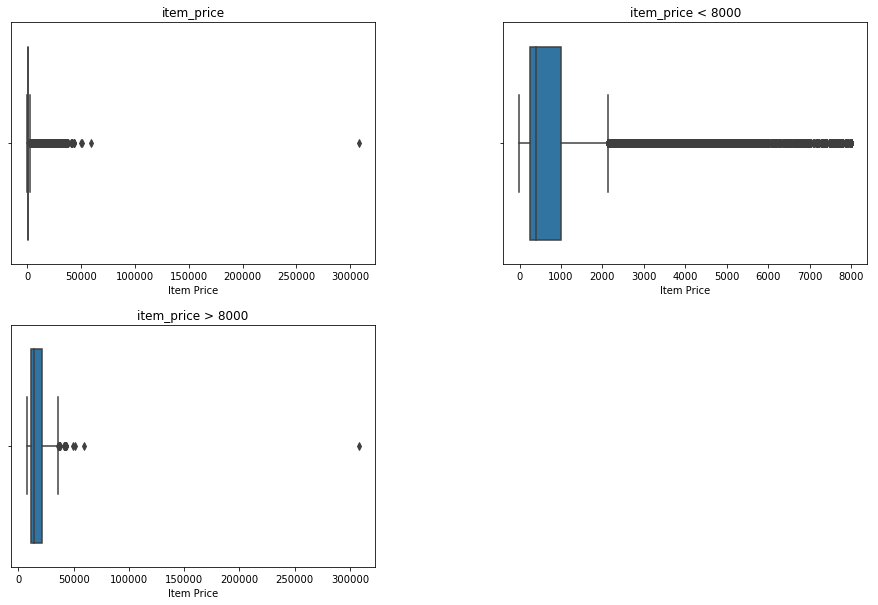

In [13]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
sns.boxplot(x = train_clean['item_price'])
plt.title('item_price')
plt.xlabel('Item Price')

plt.subplot(222)
sns.boxplot(train_clean['item_price'][train_clean.item_price < 8000])
plt.title('item_price < 8000')
plt.xlabel('Item Price')

plt.subplot(223)
sns.boxplot(train_clean['item_price'][train_clean.item_price > 8000])
plt.title('item_price > 8000')
#plt.xlim(4000, 90000)
plt.xlabel('Item Price')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

**Obs.:**
- No primeiro e no terceiro gráfico já da pra ver o valor discrepante.

O item_cnt_day também vai ter outliers, como é esperado.

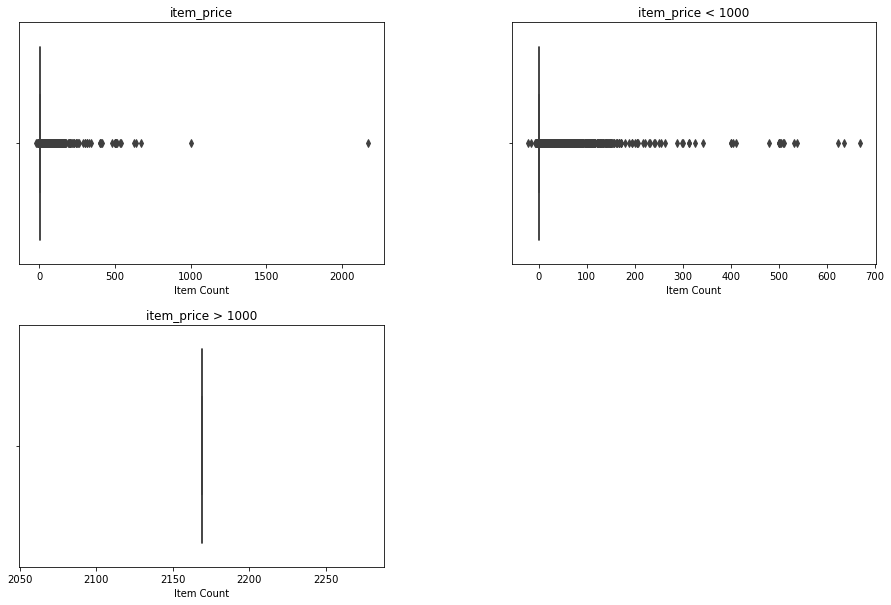

In [14]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
sns.boxplot(x = train_clean['item_cnt_day'])
plt.title('item_price')
plt.xlabel('Item Count')

plt.subplot(222)
sns.boxplot(train_clean['item_cnt_day'][train_clean.item_cnt_day < 1000])
plt.title('item_price < 1000')
plt.xlabel('Item Count')

plt.subplot(223)
sns.boxplot(train_clean['item_cnt_day'][train_clean.item_cnt_day > 1000])
plt.title('item_price > 1000')
#plt.xlim(4000, 90000)
plt.xlabel('Item Count')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

**Obs.:**
- Comparando o segundo e o terceiro gráfico, parece que só existe um outliers e está acima de mil.

O outlier:

In [15]:
train_clean[train_clean.item_cnt_day > 1000]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2909818,33,12,11373,0.908714,2169.0,9


----------------------

### <a name="vendas"></a> O que vende mais?

Vamos ver quais categórias tem o maior número de itens vendidos em todos os anos.

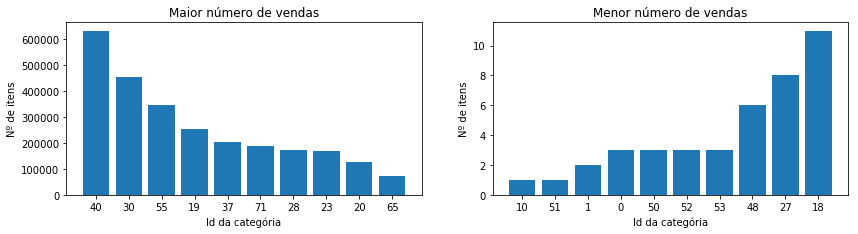

In [16]:
df = train_clean[['item_category_id', 'item_cnt_day']].groupby(
    ['item_category_id']).sum()

large = df.nlargest(n=10,columns=['item_cnt_day']).reset_index()
small = df.nsmallest(n=10,columns=['item_cnt_day']).reset_index()

x = np.linspace(1,10,10)

plt.figure(1, figsize=(14,7))

plt.subplot(221)
plt.bar(x, large['item_cnt_day'])
plt.xticks(x, large['item_category_id'])
plt.title('Maior número de vendas')
plt.xlabel('Id da categória')
plt.ylabel('Nº de itens')

plt.subplot(222)
plt.bar(x, small['item_cnt_day'])
plt.xticks(x, small['item_category_id'])
plt.title('Menor número de vendas')
plt.xlabel('Id da categória')
plt.ylabel('Nº de itens')

plt.show()

Categórias com o maior número de itens vendidos por mês.

In [17]:
# Número de categórias mostradas por mês.
n_max = 2

In [18]:
df = train_clean.pivot_table(index=['item_category_id'],
                       columns=['date_block_num'], values=['item_cnt_day'], aggfunc='sum', fill_value=0)

df.columns = df.columns.droplevel(0)

months = train_clean['date_block_num'].nunique()

for month in range(months):
    
    if month == 0:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month])#.sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)

        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum
       
    else:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n[['item_category_id_'+str(month), month]] = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True) 
        
        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum     
        
data = df_n.values.reshape((n_max, months, 3))

a = pd.date_range(start='1/2013', periods=months, freq='M')

date = [ str(a.year[month]) + '/' + str(a.month_name()[month]) for month in range(months)]

trace = [ 
            go.Bar(
                x=date,
                y=data[i, :, 1],
                text=data[i, :, 0],
                textposition = 'auto',        
            )
    
        for i in range(n_max)]

layout = go.Layout(
                    barmode='stack',
                    width=1000,
                    height=800,
         )

fig = go.Figure(data=trace, layout=layout)

iplot(fig, filename='stacked-bar')

>Repare que o número de itens vendidos está caindo com o passar dos anos.

**Os itens com maiores números de vendas são:**

    - 40: Кино - DVD => Cinema DVD
    - 30: Игры PC - Стандартные издания => Jogos de PC - Edições Standard
    - 55: Музыка - CD локального производства => Música - CD de produção local
    - 20: Игры - Аксессуары для игр => Jogos - Acessórios para jogos

### <a name="viz_cnt"></a>Visualização do número de itens vendidos por loja

Como o objetivo final é prever o número de vendas de cada item por loja, vou visualizar esses dados em um único gráfico. A ideia é colocar o número de itens vendidos por mês como uma cor, o número da loja no eixo $y$ e os meses no eixo $x$. (valor baixo = claro, valor alto = escuro)

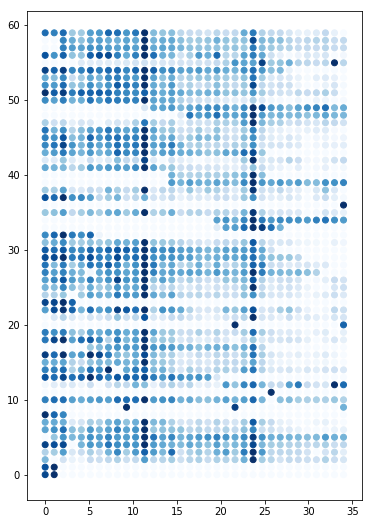

In [130]:
df = train_clean.pivot_table(index=['shop_id'],
                       columns=['date_block_num'], values=['item_cnt_day'], aggfunc='sum', fill_value=0)
df.columns = df.columns.droplevel(0)

shop_s = train['shop_id'].unique()
plt.figure(figsize=(6,9))

x = np.linspace(0,34,34)

for shop in shop_s:
    plt.scatter(x=x, y=[ shop for _ in range(34)], c=df.loc[shop, 0:34], cmap='Blues')
    
plt.show()


In [147]:
df = train_clean.pivot_table(index=['shop_id'], 
                             columns=['date_block_num'],
                             values=['item_cnt_day'],
                             aggfunc='sum', fill_value=0)

df.columns = df.columns.droplevel(0)

shop_s = train['shop_id'].unique()

x = np.linspace(0,33,33)

trace = [go.Scatter(
                x = x,
                y = [ shop for _ in range(33)],
                mode = 'markers',
                hoverinfo='y',
    
                marker = dict(
                        color = df.loc[shop, 0:33],
                        colorscale = 'Reds'
                ),
    
                showlegend=False,
            )
        for shop in shop_s]

layout = go.Layout(
                width=500,
                height=800,
                xaxis = dict(visible = False),
                yaxis = dict(visible = True, showticklabels = True),
                hovermode= 'closest',
    
        )

fig = go.Figure(trace, layout)
iplot(fig, filename='scatter')

**Obs.:**
- De forma geral, parece que as vendas caem bastante ao decorrer dos anos. Isso pode vir a ser um problema para os modelos preditivos, já que nos últimos anos as vendas vão ser quase nulas.
- Repare que tem duas retas verticais no gráfico, que são os meses de Dezembro.
- É mais fácil visualizar esse tipo de padrão quando o gráfico é mais apertado, por isso fiz width=500.

Tome muito cuidado ao olhar para essa figura. Eu não sei ao certo como o plotly está definindo as cores, pode ser o caso dele definir os dois arrays abaixo como tendo as mesmas cores,

 - $[1, 1, 0, 0]$. 
 - $[10^{10}, 10^{10}, 10^{3} 10^{3}]$.
 
Então tome cuidado ao comparar um shopping com o outro. O ideial seria deixar todos os valores em uma mesma escala e depois compara-los.

No notebook [2. Features](2.%20Criando%20as%20features.ipynb) eu criei uma função que facilita fazer essas escalas em colunas, caso queira dar uma olhada.

**Obs.:** Tem muita coisa estranha nesse gráfico.
    - Os shoppings 0 e 1 tem um número de vendas altas nos dois primeiros meses, depois é tudo zero.
    - O shopping 9 só tem vendas no natal e são altas, como é o esperado.
    - O shopping 11 só tem uma venda.
    - O shopping 33 praticamente não vende nada.

Aqui acaba a primeira parte do notebook [1. EDA](1.%20EDA.ipynb). A partir de agora irei usar features criadas no notebook [2. Features](2.%20Criando%20as%20features.ipynb), se quiser saber em detalhes como fazer é só ir lá.

### <a name="eda_basic"></a>Resumo da EDA básica:
1. Temos que retirar os outliers:
    1. Retirar linhas onde o item_price é maior que $100.000$.
    - Retirar linhas onde o item_cnt_day é maior que $1000$.
    - Retirar linhas onde o item_price é negativo.
- O desvio padrão de algumas features estão altos, dependendo do modelo temos que normalizar isso.
- Como as features possuem valores em escalas diferentes, por exemplo item_cnt_day e item_price, provavelmente teremos que normalizar isso também.
- Algumas lojas possuem o número de vendas estranhas, tipo a loja que só tem registro de vendas em dezembro. Talvez seja necessário preencher essas lacunas.
- É o ano de lançamento do PS4, então as vendas de consoles e jogos estão em alta. Isso pode ser um problema para previsões futuras, já que temos dados com viés. Porém, por ser um dataset do Kaggle e só queiramos prever um mês no futuro, isso possa ser usado como vantagem.

### Código para retirar os outliers:

In [20]:
train_clean = train_clean[train_clean.item_price < 100000]
train_clean = train_clean[train_clean.item_cnt_day < 1001]
train_clean.drop(484683, axis=0, inplace=True)

 **Se quiser entender como as features novas foram criadas, é só ir para o notebook [2. Features](2.%20Criando%20as%20features.ipynb)**

# EDA das Novas Features

Vou adicionar as features novas, criadas no notebook [2. Features](2.%20Criando%20as%20features.ipynb) e retirar os outliers. (Só é necessário [Carregar os arquivos](#Carregando-os-arquivos), não precisa rodar o notebook inteiro.)

   - [Qual categória remunera mais?](#cat_rev)
   - [Visualização da receito por loja](#viz_rev)
   - [Correlações das features novas](#new_corr)  
   - [Resumo da EDA das novas features](#eda_not_basic)

In [2]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = pd.merge(shops, geo, left_on='city', right_on='name').fillna(0)
shops.drop(['name'], axis=1, inplace=True)
items_cat['split'] = items_cat['item_category_name'].str.split('-')
items_cat['type'] = items_cat['split'].map(lambda x: x[0].strip())
items_cat['type_code'] = LabelEncoder().fit_transform(items_cat['type'])
items_cat['subtype'] = items_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_cat['subtype_code'] = LabelEncoder().fit_transform(items_cat['subtype'])
train['Dezembro'] = 0
train['Dezembro'][(train.date_block_num + 1) % 12 == 0]  = 1
train['Maio'] = 0
train['Maio'][(train.date_block_num + 1) % 6 == 0]  = 1
train['revenue'] = train['item_price'] * train['item_cnt_day']
col = ['date_block_num', 'item_price', 'item_cnt_day', 'revenue', 'shop_id']
group_index = ['date_block_num', 'shop_id']
aux = train[col].groupby(group_index).mean().reset_index()
aux.rename(columns={'item_cnt_day':'item_cnt-(mean_shop)',
                    'revenue':'revenue-(mean_shop)', 'item_price':'item_price-(mean_shop)'}, inplace=True)
train = pd.merge(train, aux, on=group_index, how='inner')
col = ['date_block_num', 'item_cnt_day', 'revenue', 'item_id']
group_index = ['date_block_num', 'item_id']
aux = train[col].groupby(group_index).mean()
aux.rename(columns={'item_cnt_day':'item_cnt-(mean_item)',
                    'revenue':'revenue-(mean_item)'}, inplace=True)
train = pd.merge(train, aux, left_on=group_index, right_index=True, how='inner')
del aux
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]
train.drop(484683, axis=0, inplace=True)
train.drop(['date'], axis=1, inplace=True)

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Unindo as features em um único dataframe.

In [3]:
df_clean = pd.merge(train, shops, on=['shop_id'], how='left')
df_clean = pd.merge(df_clean, items, on=['item_id'], how='left')
df_clean = pd.merge(df_clean, items_cat, on=['item_category_id'], how='left')

df_clean.drop(['shop_name', 'item_name', 'city',
         'item_category_name', 'split',
         'type', 'subtype'], axis=1, inplace=True)

A cara do dataframe:

In [5]:
df_clean.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,Dezembro,Maio,revenue,item_price-(mean_shop),item_cnt-(mean_shop),revenue-(mean_shop),item_cnt-(mean_item),revenue-(mean_item),city_code,name_PT-BR,latitude,longitude,item_category_id,type_code,subtype_code
0,0,59,22154,999.0,1.0,0,0,999.0,820.174553,1.092041,884.369789,1.0,999.0,30,Yaroslavl,57.626076,39.884472,37,11,1
1,0,25,22154,999.0,1.0,0,0,999.0,672.071345,1.178454,771.263539,1.0,999.0,13,Moscou,55.755871,37.617680,37,11,1
2,0,25,22154,999.0,1.0,0,0,999.0,672.071345,1.178454,771.263539,1.0,999.0,13,Moscou,55.755871,37.617680,37,11,1
3,0,25,22154,999.0,1.0,0,0,999.0,672.071345,1.178454,771.263539,1.0,999.0,13,Moscou,55.755871,37.617680,37,11,1
4,0,25,22154,999.0,1.0,0,0,999.0,672.071345,1.178454,771.263539,1.0,999.0,13,Moscou,55.755871,37.617680,37,11,1


### <a name="cat_rev"></a>Qual categória remunera mais?

Como temos a feature revenue, faz mais sentido olhar para os itens que dão mais lucro do que para o número de itens vendidos, como foi feito aqui: [O que vende mais?](#vendas). No fim das contas o que importa é o lucro da loja :) .

In [6]:
df = df_clean.pivot_table(index=['item_category_id'],
                       columns=['date_block_num'], values=['revenue'], aggfunc='sum', fill_value=0)

df.columns = df.columns.droplevel(0)

months = df_clean['date_block_num'].nunique()
n_max = 3

for month in range(months):
    
    if month == 0:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)

        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum
       
    else:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n[['item_category_id_'+str(month), month]] = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True) 
        
        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum     
        
data = df_n.values.reshape((n_max, months, 3))

a = pd.date_range(start='1/2013', periods=months, freq='M')

date = [ str(a.year[month]) + '/' + str(a.month_name()[month]) for month in range(months)]

trace = [ 
    go.Bar(
        x=date,
        y=data[i, :, 1],
        text=data[i, :, 0],
        textposition = 'auto',        
    )
    for i in range(n_max)]

layout = go.Layout(
    barmode='stack',
    width=1000,
    height=800,
)

fig = go.Figure(data=trace, layout=layout)
iplot(fig, filename='stacked-bar')

**Obs.:**

As categórias com maior lucro:

- 19: Игры - PS3 => Jogos - PS3
- 12: Игровые консоли - PS4 => Consolas de jogos - PS4
- 20: Игры - PS4 => Jogos - PS4

> Bem diferente das categórias mais vendidas, apesar delas aparecerem (40 - DVD, 30 - Jogo de Pc). [O que vende mais?](#vendas)

> **Obs.:** Parece que esse foi o ano de lançamento do PS4, o número alto de vendas do console e dos jogos indicam isso. Se tivessemos que montar um modelo para prever as vendas muitos anos depois, é possível que essa oscilação prejudicasse as previsões.

Vou olhar com mais detalhes as vendas, fazendo o gráfico com o tipo dos items mais vendidos.

In [7]:
df = df_clean.pivot_table(index=['type_code'],
                       columns=['date_block_num'], values=['revenue'], aggfunc='sum', fill_value=0)

df.columns = df.columns.droplevel(0)

months = df_clean['date_block_num'].nunique()
n_max = 3

for month in range(months):
    
    if month == 0:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)

        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum
       
    else:
        aux = df[[month]].reset_index()
        
        norm_sum = aux[month].sum() / 100
        
        aux = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True)
        aux.index = pd.RangeIndex(len(aux.index))
        
        df_n[['item_category_id_'+str(month), month]] = aux.nlargest(n=n_max, columns=[month]).sort_values(by=month, ascending=True) 
        
        df_n[str(month)+'_%'] = df_n.loc[:, month] / norm_sum     
        
data = df_n.values.reshape((n_max, months, 3))

a = pd.date_range(start='1/2013', periods=months, freq='M')

date = [ str(a.year[month]) + '/' + str(a.month_name()[month]) for month in range(months)]

trace = [ 
    go.Bar(
        x=date,
        y=data[i, :, 1],
        text=data[i, :, 0],
        textposition = 'auto',        
    )
    for i in range(n_max)]

layout = go.Layout(
    barmode='stack',
    width=1000,
    height=800,
)

fig = go.Figure(data=trace, layout=layout)
iplot(fig, filename='stacked-bar')

> Nada de novo. O que dá mais lucro são os video games e o lucro aumenta no Natal.

### <a name="viz_rev"></a>Visualização da receita por loja

Espero encontrar o mesmo padrão do gráfico feito em [Visualização do número de itens vendidos por loja](#viz_cnt).

In [8]:
df = df_clean.pivot_table(index=['shop_id'],
                       columns=['date_block_num'], values=['revenue'], aggfunc='sum', fill_value=0)
df.columns = df.columns.droplevel(0)

shop_s = train['shop_id'].unique()
plt.figure(figsize=(14,10))

x = np.linspace(0,33,33)

trace = [ go.Scatter(
    x = x,
    y = [ shop for _ in range(33)],
    mode = 'markers',
    marker = dict(
        color = df.loc[shop, 0:33],
        colorscale = 'Reds'
    ),
    showlegend=False,
)
for shop in shop_s]

layout = go.Layout(
    width=500,
    height=800,
    xaxis = dict(visible = False),
    yaxis = dict(visible = True, showticklabels = True),
    
)

fig = go.Figure(trace, layout)
iplot(fig, filename='basic-scatter')

<Figure size 1008x720 with 0 Axes>

### <a name="new_corr"></a>Correlações das features novas

Esse mapa de correlações vai ser mais interessante. Repare que, obviamente, alguns dados vão estar altamente correlacionados, como o shop_id e city. É possível usar algumas técnicas como PCA ([3.PCA](3.%20PCA.ipynb)), para reduzir o número de features e sempre é possível descartarmos algumas features. Por exemplo, eu acho que city, onde você possui informação de quais lojas estão próximas, tem muito mais informação que o shop_id, que é só um número. Talvez descartar essa última ajude o algoritmo.

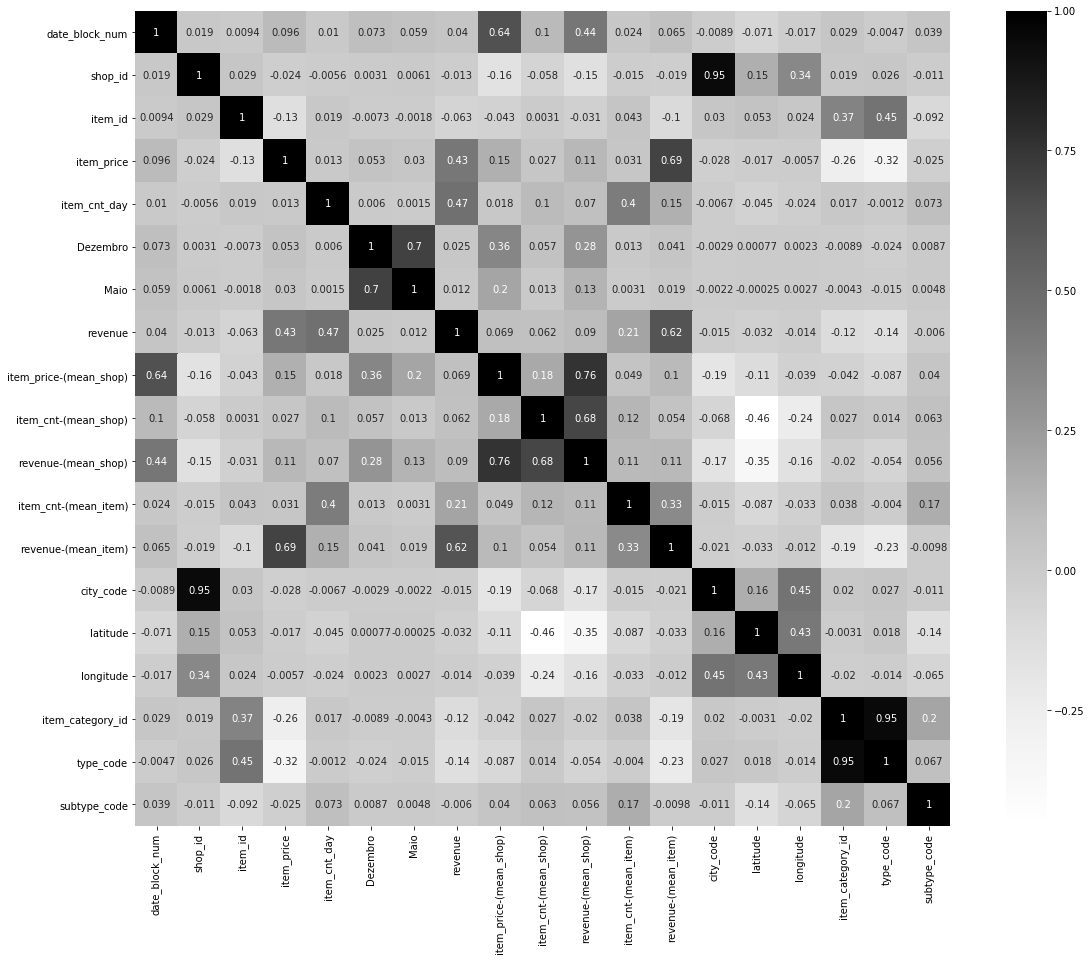

In [10]:
correlation = df_clean.corr()
plt.figure(figsize=(20,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='Greys')
plt.show()

**Obs.:** (Coisas interessantes)

- Longitude e shop_id: Provavelmente as lojas foram númeradas da esquerda para a direita, considerando o mapa mundi.
- Dezembro, revenue-(mean_shop), item_price-(mean_shop): As vendas sobem no natal por isso temos uma correlação.
- Item_price, item_cnt_day e revenue: Como revenue é a multiplicação de item_price por item_cnt_day, é esperado que elas tenham alguma correlação.
- date_block_num, revenue-(mean_shop) e item_price-(mean_shop): As vendas mudam dependendo do período do ano, por isso temos uma correlação.


> Se quiser ter uma visualização mais limpa das correlações é só substituir: correlation = df_clean.corr().clip(0.1, 1). A ideia é não visualizar correlações menores que 0.1, que é um valor baixo.

### <a name="eda_not_basic"></a>Resumo da EDA das novas features:

1. A quantidade de itens vendidos por mês tem uma distribuição estranha, alguns parecem faltar informações em alguns meses ou a loja só abre nesses períodos.
2. Shop_id e city_code são praticamente a mesma feature, assim como item_category_id e type_code. Talvez possamos elimar uma delas. 
3. O mês de Dezembro é importante para as vendas. 
4. A categória que mais remunera são as de video games, mais provavelmente porque foi o ano de lançamento do PS4.

# Show off

A partir da feature city, eu criei um dataset com as posições geograficas. Também deixei a tradução do nome da cidade, perceba que existem algumas lojas online.

Seria interessante obter a temperatura na cidade nas datas e adicionar como feature. Talvez as lojas onlines tenham vantagens em algumas épocas do ano.

Talvez eu adicione esses dados como features e o modelo possa reconhcer a distância entre as cidades.

In [28]:
geo.head(8)

,name,name_PT-BR,latitude,longitude
0,Адыгея,Adygea,44.488950,39.730820
1,Балашиха,Balashikha,55.797040,37.934500
2,Волжский,Volzhsky,48.786300,44.751570
3,Вологда,Vologda,59.218067,39.897804
4,Воронеж,Voronezh,51.675495,39.208881
5,Выездная,Sair,45.157089,42.966549
6,Жуковский,Zhukovsky,55.577942,38.125069
7,Интернет-магазин,Loja Online,NaN,NaN


In [29]:
# Drop as linhas com nan
geo.dropna(inplace=True)

In [30]:
df = df_clean.pivot_table(index=['name_PT-BR'],
                       columns=['date_block_num'], values=['item_cnt_day'], aggfunc='sum', fill_value=0)
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)

In [31]:
m = folium.Map(location=[60.0, 85.0], tiles='stamentoner', zoom_start=3)

data = []

for idx, city in enumerate(geo['name_PT-BR']):
    
    lat = geo.iloc[idx, 2]
    long = geo.iloc[idx, 3]
    heat = df.loc[:, 0][df['name_PT-BR'] == city ].values[0]
    folium.Marker([lat, long], tooltip=city).add_to(m)
    data.append([lat, long, heat]) 
    
plugins.HeatMap(data).add_to(m)

m

A ideia era ter uma visualização no tempo do número de itens vendidos por shopping, mas não deu certo.

In [32]:
m = folium.Map(location=[60.0, 85.0], tiles='stamentoner', zoom_start=3)

data_f = []

for time in range(33):

    data = []

    for idx, city in enumerate(geo['name_PT-BR']):
    
        lat = geo.iloc[idx, 2]
        long = geo.iloc[idx, 3]
        heat = df.loc[:, 0][df['name_PT-BR'] == city ].values[0]
        
        folium.Marker([lat, long], tooltip=city).add_to(m)
        
        data.append([lat, long, time+2000]) 
        
    data_f.append(data)
    
hm = plugins.HeatMapWithTime(data_f)

hm.add_to(m)

m


https://python-graph-gallery.com/map/

- [GeoPandas](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Geopandas_and_geo_interface.ipynb)
- [HeatmapWithTime](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/HeatMapWithTime.ipynb)
- [Heatmap](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Heatmap.ipynb)
- [Pluggin](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Plugins.ipynb)
- [Popups](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Popups.ipynb)
- [Timeslider](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb)
- [Search](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/plugin-Search.ipynb)
- [Folium](https://github.com/python-visualization/folium)

# Apéndice

#### <a name="nan"></a> Criando o dataframe com nans para ser visualizado.

[Voltar ao notebook](#backnan)


In [33]:
a = np.zeros((10,4))
a[4, :] = np.nan
a[8, :] = np.nan

a = pd.DataFrame(a)

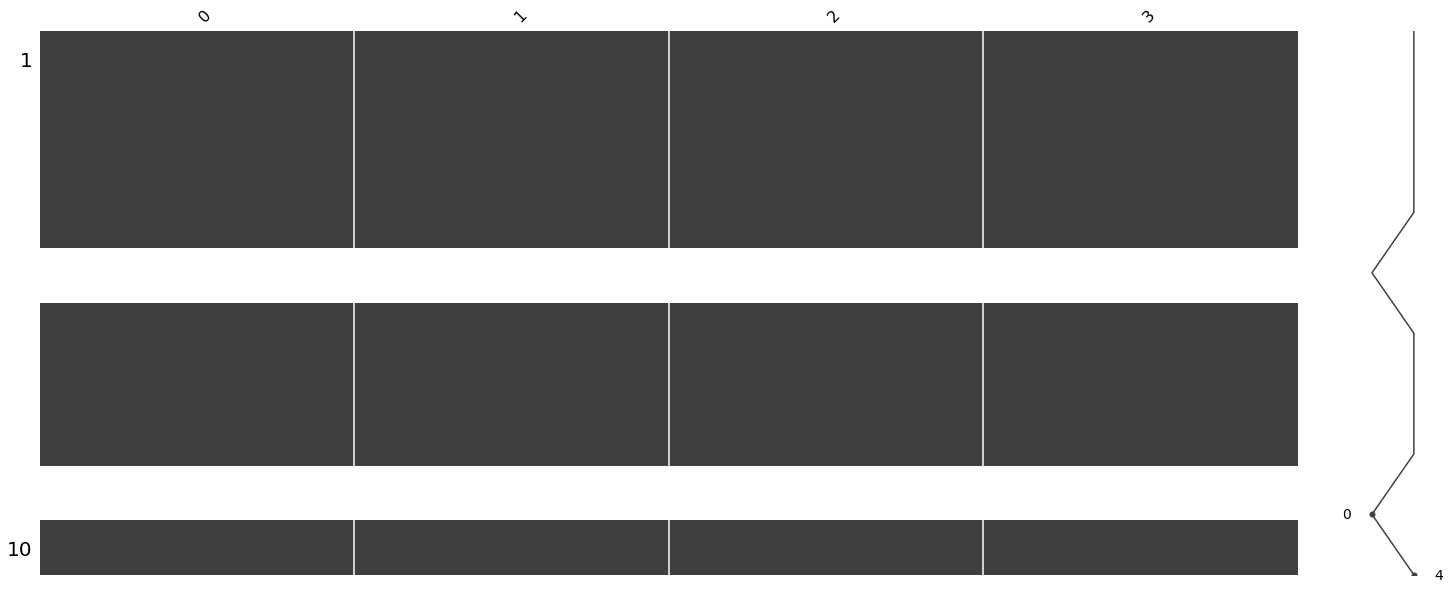

In [34]:
msno.matrix(a)

Mapa de correlações dos nans.

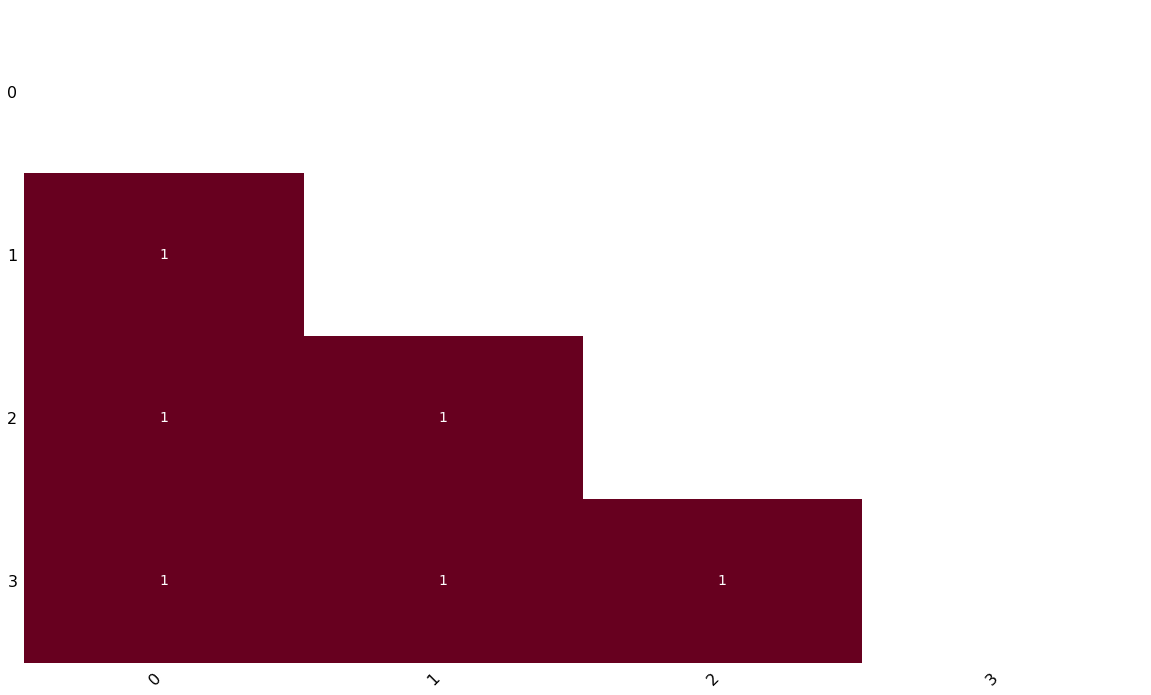

In [35]:
msno.heatmap(a)
plt.show()

# Referências

- Site da competição [Kaggle Competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)
- Site várias correlações: [spurious correlations](http://www.tylervigen.com/spurious-correlations)